In [1]:
from collections import Counter

import numpy as np

import cv2
from imageio import imread
import matplotlib.pyplot as plt

In [2]:
dirname = 'stopsign/'
img_ref = imread(dirname + 'stop-reference.jpg')
img1 = imread(dirname + 'stop1.jpg')
img4 = imread(dirname + 'stop4.jpg')

In [3]:
def extract_correspondences(im1, im2, coeff=0.5):
    """
    im1: image to match
    im2: reference image
    return two lists of good-match keypoints
    """
    sift = cv2.xfeatures2d.SIFT_create()
    keypts1, desc1 = sift.detectAndCompute(im1, None)
    keypts2, desc2 = sift.detectAndCompute(im2, None)
    matches = cv2.BFMatcher().knnMatch(desc1, desc2, k=2)
    
    # find good matches above threshold
    good_keypts1 = []
    good_keypts2 = []
    for m1, m2 in matches:
        if m1.distance > coeff * m2.distance:
            continue
        good1 = keypts1[m1.queryIdx]
        good2 = keypts2[m1.trainIdx]
        good_keypts1.append(good1)
        good_keypts2.append(good2)
        
    return good_keypts1, good_keypts2

In [4]:
def get_vertices(im_ref):
    height, width = im_ref.shape[:2]
    points = np.stack([
        (0, 0), (width, 0), (width, height), (0, height)
    ]).astype(np.float32)
    return points

def reshape_vertices_for_cv2(points):
    vertices  = points.reshape((-1,1,2)).astype(np.int32)
    return vertices

def draw_bounding_box(im, vertices):
    ret = cv2.polylines(im.copy(), [vertices], isClosed=True, 
                   color=(0, 255, 255), thickness=5)
    return ret

In [137]:
def rotate(p, degrees, origin=(0, 0)):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    ret = np.squeeze((R @ (p.T-o.T) + o.T).T)
    return ret

In [154]:
def convert_vertices_using_params(points, params):
    """
    helper for visualization, probabaly not used in final
    vertices: from the reference image
    keypt: a single keypoint
    """
    scale, angle, _, _ = params
    kp_pt = params[2:]
    orig_pt = params[]
     
    # translation
    points += kp_pt
    
    # scale
    points *= scale
    
    # rotation
#     points = rotate(points, angle, origin=kp_pt)
    points = rotate(points, 90, origin=kp_pt)
    
    return points

In [155]:
def get_hough_votes(keypoints):
    # before quantization
    votes_raw = np.vstack([
        (kp.size, 
         kp.angle, 
         kp.pt[0], 
         kp.pt[1]) for kp in keypoints
    ])
    
    # two bins for each voting param
    upper = votes_raw.max(axis=0)
    lower = votes_raw.min(axis=0)
    middle = (upper + lower) / 2
    dist = middle - lower
    bins = np.vstack([
        lower - dist,
        middle,
        upper + dist
    ])
    
    # quantize votes into bins
    votes = np.vstack([
        np.digitize(votes_raw[:, i], bins[:, i], right=False)
        for i in range(votes_raw.shape[1])
    ]).T
    
    # count popular votes
    vote_tuples = tuple([tuple(row) for row in votes])
    vote_counter = Counter(vote_tuples)
    
    winner = vote_counter.most_common()[0][0]
    # keypoints that voted the winning vote
    keypoint_indices = np.where((votes == winner).all(axis=1))[0]
    
    return keypoint_indices

In [148]:
# maybe just for now
def get_bounding_box_params(kpt_indices, kpts, kpts_ref):
    params = np.vstack([
        (kpts[idx].size / kpts_ref[idx].size, 
         kpts[idx].angle - kpts_ref[idx].angle, 
         kpts[idx].pt[0] - kpts_ref[idx].pt[0], 
         kpts[idx].pt[1] - kpts_ref[idx].pt[1])
        for idx in kpt_indices
    ]).mean(axis=0)
    
    return params

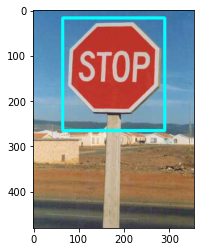

In [149]:
points_ref = get_vertices(img_ref)
kpts, kpts_ref = extract_correspondences(img1, img_ref)
kpt_indices = get_hough_votes(kpts)
params = get_bounding_box_params(kpt_indices, kpts, kpts_ref)
points = convert_vertices_using_params(points_ref, params)
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)

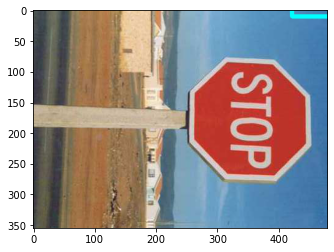

In [156]:
# rotate img1
img1rot = cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE)
points_ref = get_vertices(img_ref)
kpts, kpts_ref = extract_correspondences(img1rot, img_ref)
kpt_indices = get_hough_votes(kpts)
params = get_bounding_box_params(kpt_indices, kpts, kpts_ref)
points = convert_vertices_using_params(points_ref, params)
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1rot, vertices)
plt.imshow(im)

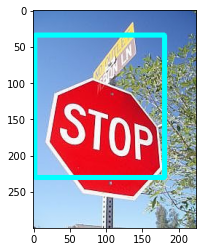

In [151]:
points_ref = get_vertices(img_ref)
kpts, kpts_ref = extract_correspondences(img4, img_ref)
kpt_indices = get_hough_votes(kpts)
params = get_bounding_box_params(kpt_indices, kpts, kpts_ref)
points = convert_vertices_using_params(points_ref, params)
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img4, vertices)
plt.imshow(im)